# Final Project Report
## Noam Siegel
### Physiological Signal Processing, Ben Gurion University
 #### 367-2-6351



In [1]:
% load_ext autoreload
% autoreload 2

import itertools

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from msc.config import get_config
from msc.dataset import RawDataset, PSPDataset
from msc.dataset.dataset import get_datasets_df
from scripts.psp.analysis.data_visualizations import plot_pca_projection
from scripts.psp.analysis.imshow_dataset import plot_feature_window
from scripts.psp.analysis.plot_feature_window import plot_results_score
from scripts.psp.analysis.plot_feature_window import plot_results_time
from scripts.psp.build_dataset import build_dataset
from scripts.psp.training import classifier_comparison


## Load configurations

In [10]:
config = get_config()
config

{'PATH': {'LOCAL': {'RAW_DATASET': 'C:\\raw_data\\epilepsiae',
   'RESULTS': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results',
   'PSP_DATASET': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results\\epilepsiae'},
  'BGUCLUSTER': {'RAW_DATASET': '/cs_storage/noamsi/raw_data/epilepsiae/',
   'RESULTS': '/cs_storage/noamsi/results/',
   'PSP_DATASET': '/cs_storage/noamsi/results/epilepsiae/'},
  'MIRIAM': {'RAW_DATASET': '\\\\132.72.65.115\\epilepsy_data\\Epilepsiea\\raw_data'}},
 'TASK': {'PICKS': 'one_channel',
  'RESAMPLE': '256',
  'PREICTAL_MIN_DIFF_HOURS': '1',
  'INTERICTAL_MIN_DIFF_HOURS': '4',
  'PREICTAL_LABEL': '0',
  'INTERICTAL_LABEL': '1'},
 'RESULTS': {'LOCAL': None,
  'BGUCLUSTER': {'RESULTS_DIR': '/cs_storage/noamsi/results'}},
 'DATASET': 'epilepsiae',
 'RAW_MACHINE': 'MIRIAM',
 'RESULTS_MACHINE': 'LOCAL'}

## Get Raw dataset

In [11]:
raw_dataset = RawDataset(f"{config['PATH']['MIRIAM']['RAW_DATASET']}")
raw_dataset.data_df

,package,patient,admission,recording,fname,meas_date,end_date,time_zone,sfreq,nsamples,time_hours,nchan,ch_names,highpass,lowpass,fpath,seizure_table,num_seizures
0,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_018.data,2009-05-20 08:27:43,2009-05-20 08:34:56,UTC,400.0,173550,0.120521,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
1,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_012.data,2009-05-20 02:53:25,2009-05-20 03:49:08,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
2,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_010.data,2009-05-20 01:01:59,2009-05-20 01:57:42,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
3,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_004.data,2009-05-19 19:27:41,2009-05-19 20:23:24,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
4,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_003.data,2009-05-19 18:31:58,2009-05-19 19:27:41,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17519,CO,pat_7800,adm_780100,rec_78010100,78010100_0057.data,2011-09-16 09:38:24,2011-09-16 11:38:24,UTC,1024.0,7372896,2.000026,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17520,CO,pat_7800,adm_780100,rec_78010100,78010100_0037.data,2011-09-15 05:55:27,2011-09-15 07:24:03,UTC,1024.0,5443712,1.476701,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,1
17521,CO,pat_7800,adm_780100,rec_78010100,78010100_0061.data,2011-09-16 16:18:40,2011-09-16 17:33:55,UTC,1024.0,4623808,1.254288,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17522,CO,pat_7800,adm_780100,rec_78010100,78010100_0042.data,2011-09-15 14:45:14,2011-09-15 15:20:22,UTC,1024.0,2159584,0.585825,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0


## Select random data file

In [12]:
data_row = raw_dataset.data_df.query("package == 'surfCO' and patient == 'pat_3500'").sample(1)
data_row.transpose()

,10659
package,surfCO
patient,pat_3500
admission,adm_350100
recording,rec_35010100
fname,35010100_0027.data
meas_date,2009-11-18 09:32:06
end_date,2009-11-18 09:57:40
time_zone,UTC
sfreq,1024.0
nsamples,1570976


## Plot raw data

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2009-11-18 09:32:06 UTC
 nchan: 32
 projs: []
 sfreq: 1024.0 Hz
>


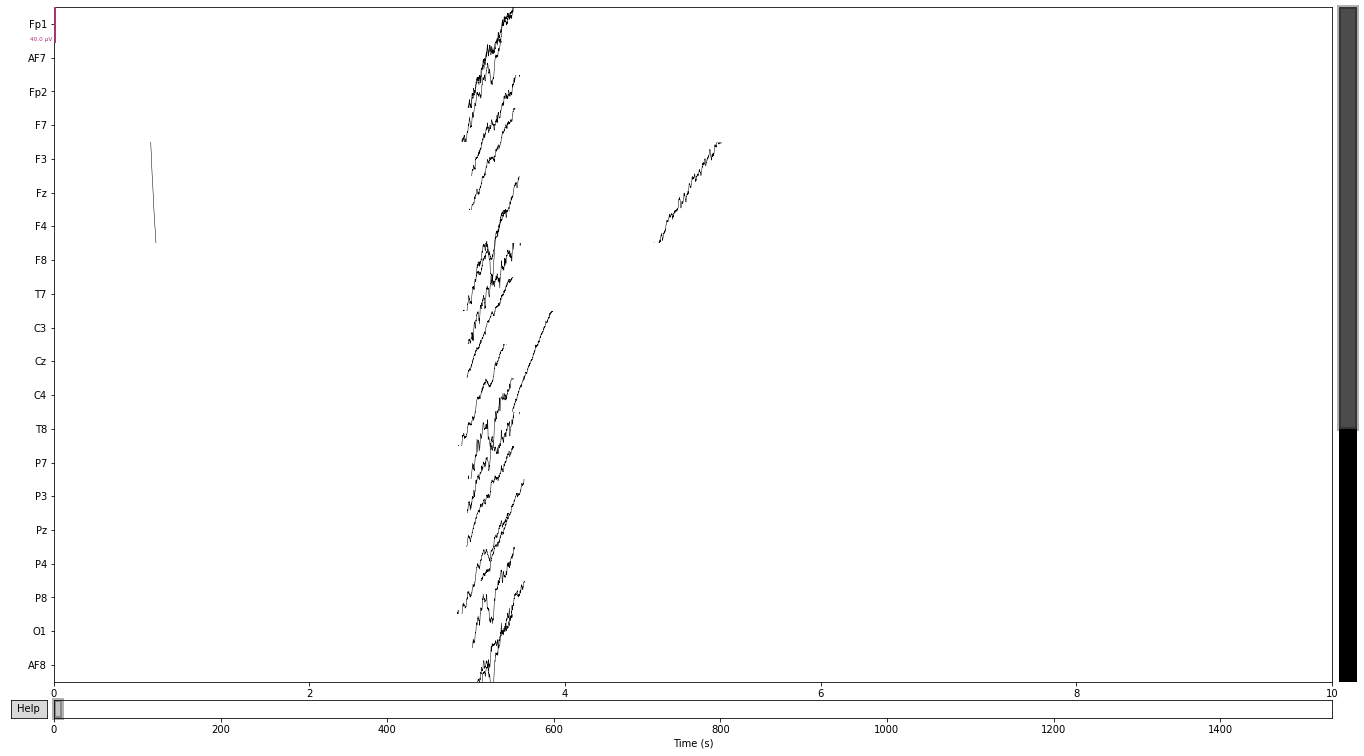

In [13]:
raw = raw_dataset.get_raw(data_row)
print(raw.info)
raw.plot();

## Feature Extraction
### Build Dataset (Demo)

In [14]:
available_features = ['max_cross_corr', 'phase_lock_val', 'nonlin_interdep', 'time_corr', 'spect_corr']
selected_feature = available_features[0]
package = 'surfCO'
selected_patient = 'pat_3500'

raw_args = ['--dev', '-p', selected_patient, '-f', selected_feature]

build_dataset.main(raw_args)

Starting build_dataset.py with fast_dev_mode=True at time 20211219T024058
WARNING! fast_dev_mode=True !!! Results are incomplete.
dumping results to C:\Users\noam\Repositories\noamsgl\msc\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058
getting selected_func='max_cross_corr' for patient='pat_3500' from package='surfCO'
len(preictal_intervals)=5
len(interictal_intervals)=6
len(preictal_window_intervals)=2
len(interictal_window_intervals)=2


loading patient data: 100%|██████████| 61/61 [01:07<00:00,  1.11s/it]


len(preictal_raws)=2
starting to extract features for preictal raws
dumping window_id=0 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_0.pkl'
dumping window_id=1 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_1.pkl'


loading patient data: 100%|██████████| 61/61 [01:52<00:00,  1.84s/it]


[<RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>, <RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>]
starting to extract features for interictal raws
dumping window_id=2 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_2.pkl'
dumping window_id=3 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_3.pkl'
saving samples_df to samples_df_path='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/dataset.csv'


## Load index of existing datasets

In [6]:
datasets_df = get_datasets_df()
datasets_df

,feature_name,patient_name,data_dir
0,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,max_cross_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
2,max_cross_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
3,phase_lock_val,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,phase_lock_val,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
5,phase_lock_val,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
6,spect_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
7,spect_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
8,spect_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
9,time_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


## Visualize Features
Assumes many datasets have been built

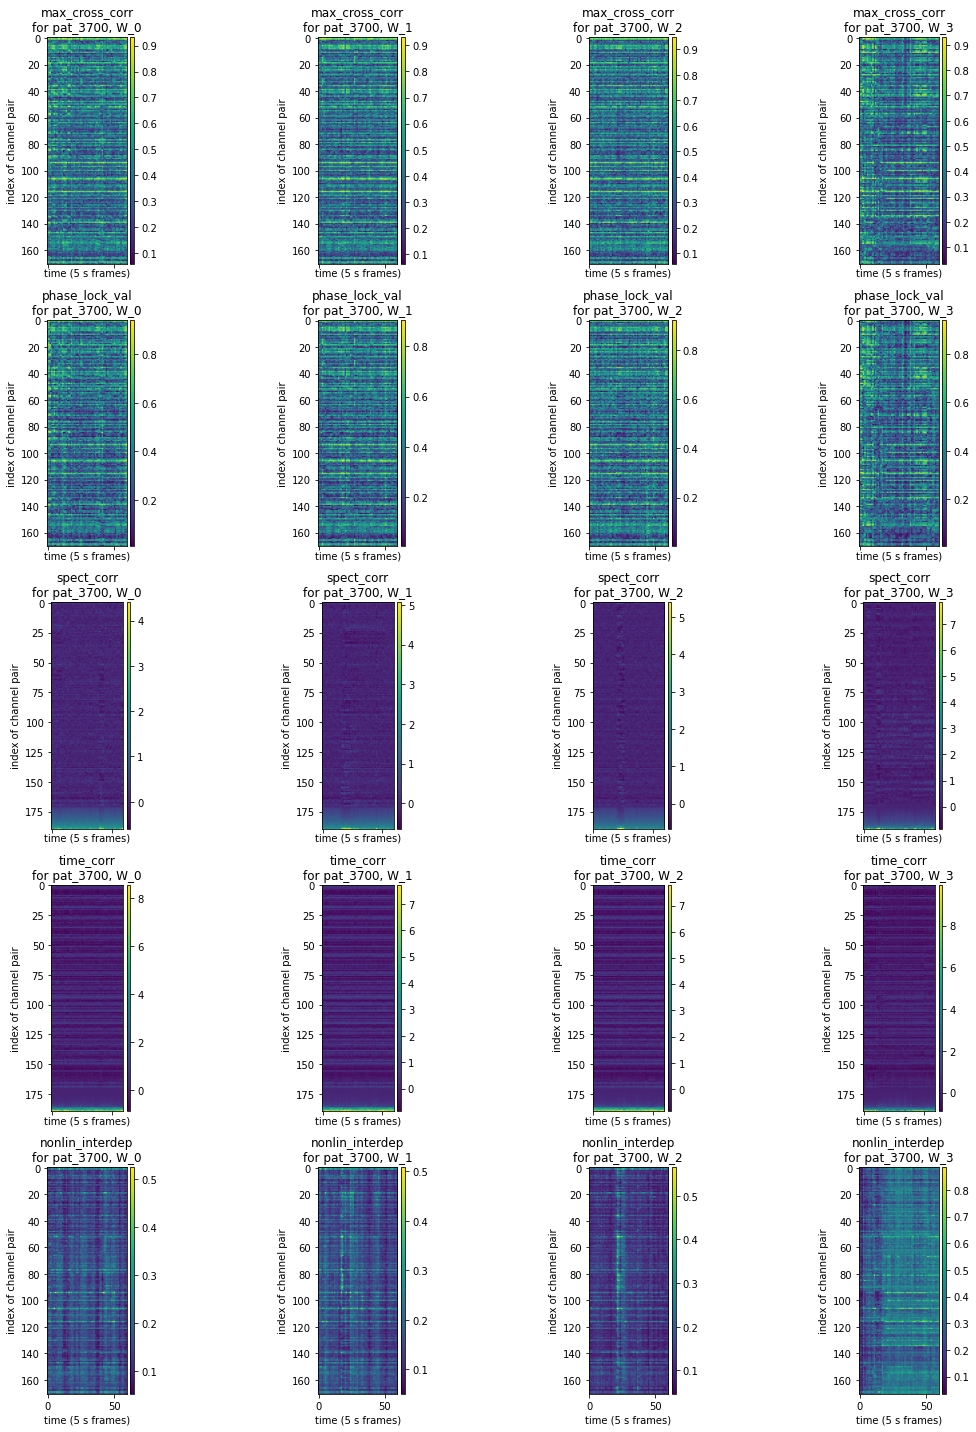

In [11]:
selected_patient = 'pat_3700'
patients_datasets_df = datasets_df.query(f"patient_name == '{selected_patient}'").reset_index()
nrows = len(patients_datasets_df)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=False)
for i in range(nrows):
    dataset = patients_datasets_df.loc[i]
    psp_dataset = PSPDataset(dataset.data_dir)
    X, labels = psp_dataset.get_X(), psp_dataset.get_labels(format='desc')
    for j in range(ncols):
        plot_feature_window(X[j].reshape(-1, 60), patient_name=selected_patient, window_name=f'W_{j}',
                            feature_name=dataset.feature_name, ax=axes[i, j])
plt.tight_layout()
plt.show()


## Visualize Datasets
We show a PCA projection to 2 dimensions for 12 different datasets.

plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 1, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 2, dtype: object
plotting pca for feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object
plotting pca for feature_name                   

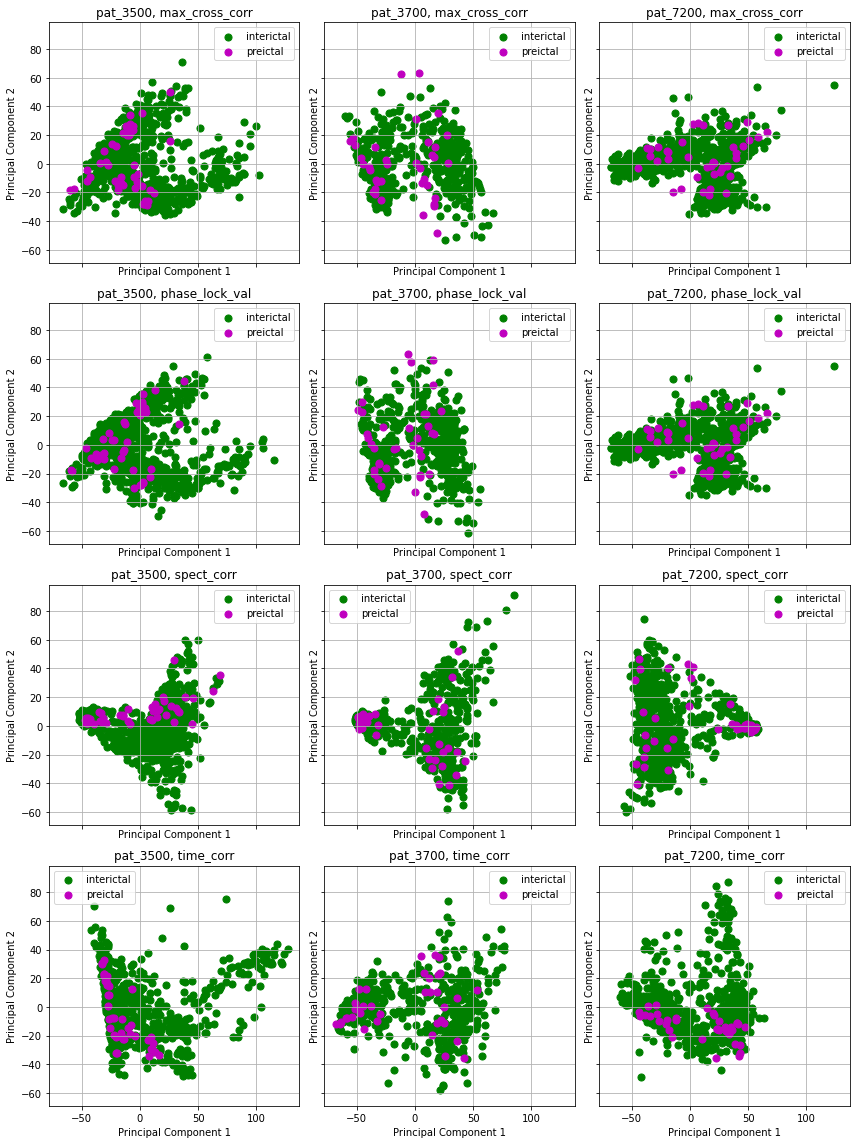

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    plot_pca_projection(datasets_df.sort_values(by=['feature_name', 'patient_name'], ignore_index=True).loc[i], ax=ax)
plt.tight_layout()
plt.show()


## Train classifier on multiple feature datasets at once

In [57]:
feature_names = (
    # 'max_cross_corr',
    # 'phase_lock_val',
    # 'spect_corr',
    # 'time_corr',
    'nonlin_interdep',
)

patient_names = [
    # 'pat_3500',
    'pat_3700',
    # 'pat_7200'
]

classifier_names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
new_results = classifier_comparison.main(save_to_disk=False,
                                     feature_names=feature_names,
                                     patient_names=patient_names,
                                     classifier_names=classifier_names)

iterating datasets:   0%|          | 0/1 [00:00<?, ?it/s]

beginning ds=feature_name                                      nonlin_interdep
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 13, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [04:07<00:34, 34.26s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

In [60]:
new_results = new_results.set_index(['patient_name', 'feature_name', 'classifier_name'])
new_results

fold   fit_time  score_time  \
patient_name feature_name    classifier_name                                  
pat_3700     nonlin_interdep Nearest Neighbors     0   0.015001    0.039999   
                             Nearest Neighbors     1   0.008001    0.025002   
                             Nearest Neighbors     2   0.008998    0.024000   
                             Nearest Neighbors     3   0.006998    0.022000   
                             Nearest Neighbors     4   0.008999    0.021001   
                             Linear SVM            0   3.496032    1.055966   
                             Linear SVM            1   3.240999    1.176003   
                             Linear SVM            2   3.130999    1.068004   
                             Linear SVM            3   2.871999    0.921001   
                             Linear SVM            4   1.854001    0.886000   
                             RBF SVM               0   3.765962    1.961999   
                             RBF SVM               1   3.534062    1.954999   
                             RBF SVM               2   3.666521    1.962001   
                             RBF SVM               3   3.481001    1.919000   
                             RBF SVM               4   3.544977    1.953716   
                             Decision Tree         0   0.561360    0.005949   
                             Decision Tree         1   0.570051    0.003985   
                             Decision Tree         2   0.457247    0.003999   
                             Decision Tree         3   0.497966    0.005002   
                             Decision Tree         4   0.604588    0.003996   
                             Random Forest         0   0.028002    0.010000   
                             Random Forest         1   0.019010    0.007000   
                             Random Forest         2   0.022036    0.008003   
                             Random Forest         3   0.017955    0.007033   
                             Random Forest         4   0.017996    0.007004   
                             Neural Net            0   0.690993    0.008974   
                             Neural Net            1   0.680000    0.006001   
                             Neural Net            2   0.691002    0.006947   
                             Neural Net            3  35.540070    0.009004   
                             Neural Net            4  41.062561    0.006950   
                             AdaBoost              0   6.483024    0.126999   
                             AdaBoost              1   6.638637    0.137000   
                             AdaBoost              2   6.392948    0.127035   
                             AdaBoost              3   6.427072    0.117945   
                             AdaBoost              4   6.440013    0.120035   
                             Naive Bayes           0   0.031999    0.021001   
                             Naive Bayes           1   0.032999    0.023001   
                             Naive Bayes           2   0.033999    0.019001   
                             Naive Bayes           3   0.034000    0.020999   
                             Naive Bayes           4   0.034001    0.024999   
                             QDA                   0   0.387000    0.026000   
                             QDA                   1   0.405001    0.023038   
                             QDA                   2   0.404170    0.022984   
                             QDA                   3   0.391030    0.026000   
                             QDA                   4   0.396198    0.024966   

                                                                                        estimator  \
patient_name feature_name    classifier_name                                                        
pat_3700     nonlin_interdep Nearest Neighbors                KNeighborsClassifier(n_neighbors=3)   
                             Ne

In [90]:
complete_results

fold  fit_time  score_time  \
patient_name feature_name    classifier_name                                 
pat_3500     max_cross_corr  Nearest Neighbors     0  0.009007    0.029949   
                             Nearest Neighbors     1  0.009052    0.024987   
                             Nearest Neighbors     2  0.008017    0.023984   
                             Nearest Neighbors     3  0.008016    0.023985   
                             Nearest Neighbors     4  0.008025    0.024949   
...                                              ...       ...         ...   
pat_3700     nonlin_interdep QDA                   0  0.387000    0.026000   
                             QDA                   1  0.405001    0.023038   
                             QDA                   2  0.404170    0.022984   
                             QDA                   3  0.391030    0.026000   
                             QDA                   4  0.396198    0.024966   

                                                                          estimator  \
patient_name feature_name    classifier_name                                          
pat_3500     max_cross_corr  Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                             Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                             Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                             Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                             Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
...                                                                             ...   
pat_3700     nonlin_interdep QDA                    QuadraticDiscriminantAnalysis()   
                             QDA                    QuadraticDiscriminantAnalysis()   
                             QDA                    QuadraticDiscriminantAnalysis()   
                             QDA                    QuadraticDiscriminantAnalysis()   
                             QDA                    QuadraticDiscriminantAnalysis()   

                                                test_precision  test_recall  \
patient_name feature_name    classifier_name                                  
pat_3500     max_cross_corr  Nearest Neighbors        0.951613     0.967213   
                             Nearest Neighbors        0.966102     0.934426   
                             Nearest Neighbors        0.953125     1.000000   
                             Nearest Neighbors        0.953125     1.000000   
                             Nearest Neighbors        0.949153     0.918033   
...                                                        ...          ...   
pat_3700     nonlin_interdep QDA                      0.846154     0.275000   
                             QDA                      0.857143     0.307692   
                             QDA                      0.838710     0.666667   
                             QDA                      0.875000     0.358974   
                             QDA                      0.931034     0.692308   

                                                test_roc_auc  \
patient_name feature_name    classifier_name                   
pat_3500     max_cross_corr  Nearest Neighbors      0.577869   
                             Nearest Neighbors      0.568306   
                             Nearest Neighbors      0.751366   
                             Nearest Neighbors      0.751366   
                             Nearest Neighbors      0.385246   
...                                                      ...   
pat_3700     nonlin_interdep QDA                    0.487500   
                             QDA                    0.471795   
                             QDA                    0.358974   
                             QDA                    0.564103   
                             QDA                    0.679487   

                                        

<AxesSubplot:title={'center':'Comparison of Linear SVM scores on Patient 3500'}, xlabel='feature_name'>

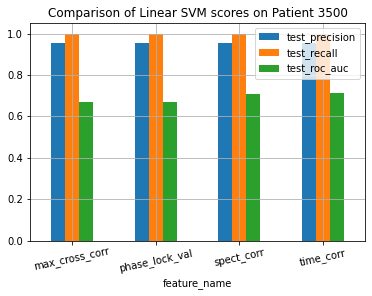

In [113]:
plot_results = complete_results.swaplevel().loc['pat_7200'].loc['Linear SVM'].groupby('feature_name').mean().loc[:,['test_precision', 'test_recall', 'test_roc_auc']]
plot_results.plot.bar(rot=12, title='Comparison of Linear SVM scores on Patient 7200', grid=True)

In [86]:
complete_results.loc['Linear SVM'].groupby(['patient_name', 'feature_name']).mean().loc[:,"test_roc_auc"]

KeyError: 'Linear SVM'

In [20]:
results = results.set_index(['patient_name', 'feature_name', 'classifier_name'])
results

fold  fit_time  score_time  \
patient_name feature_name   classifier_name                                 
pat_3500     max_cross_corr Nearest Neighbors     0  0.009007    0.029949   
                            Nearest Neighbors     1  0.009052    0.024987   
                            Nearest Neighbors     2  0.008017    0.023984   
                            Nearest Neighbors     3  0.008016    0.023985   
                            Nearest Neighbors     4  0.008025    0.024949   
...                                             ...       ...         ...   
pat_7200     time_corr      QDA                   0  0.578084    0.033984   
                            QDA                   1  0.599321    0.035982   
                            QDA                   2  0.594086    0.037982   
                            QDA                   3  0.607116    0.037038   
                            QDA                   4  0.638007    0.034977   

                                                                         estimator  \
patient_name feature_name   classifier_name                                          
pat_3500     max_cross_corr Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
...                                                                            ...   
pat_7200     time_corr      QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   

                                               test_precision  test_recall  \
patient_name feature_name   classifier_name                                  
pat_3500     max_cross_corr Nearest Neighbors        0.951613     0.967213   
                            Nearest Neighbors        0.966102     0.934426   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.949153     0.918033   
...                                                       ...          ...   
pat_7200     time_corr      QDA                      0.916667     0.180328   
                            QDA                      0.937500     0.245902   
                            QDA                      1.000000     0.344262   
                            QDA                      0.866667     0.216667   
                            QDA                      1.000000     0.283333   

                                               test_roc_auc  \
patient_name feature_name   classifier_name                   
pat_3500     max_cross_corr Nearest Neighbors      0.577869   
                            Nearest Neighbors      0.568306   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.385246   
...                                                     ...   
pat_7200     time_corr      QDA                    0.300546   
                            QDA                    0.377049   
                            QDA                    0.770492   
                            QDA                    0.300000   
                            QDA                    0.838889   

                                                                                        dat

In [23]:
results.groupby(['patient_name', 'feature_name', 'classifier_name']).mean().drop(columns='fold').add_suffix('_mean')

fit_time_mean  score_time_mean  \
patient_name feature_name   classifier_name                                     
pat_3500     max_cross_corr AdaBoost               10.538184         0.175015   
                            Decision Tree           0.711377         0.005984   
                            Linear SVM              5.959221         2.080417   
                            Naive Bayes             0.039996         0.025189   
                            Nearest Neighbors       0.008423         0.025571   
...                                                      ...              ...   
pat_7200     time_corr      Nearest Neighbors       0.010207         0.029009   
                            Neural Net             20.458914         0.009195   
                            QDA                     0.603323         0.035993   
                            RBF SVM                 7.410460         4.101780   
                            Random Forest           0.024383         0.007615   

                                               test_precision_mean  \
patient_name feature_name   classifier_name                          
pat_3500     max_cross_corr AdaBoost                      0.950192   
                            Decision Tree                 0.949398   
                            Linear SVM                    0.950192   
                            Naive Bayes                   0.947160   
                            Nearest Neighbors             0.954623   
...                                                            ...   
pat_7200     time_corr      Nearest Neighbors             0.959975   
                            Neural Net                    0.955146   
                            QDA                           0.944167   
                            RBF SVM                       0.955853   
                            Random Forest                 0.955853   

                                               test_recall_mean  \
patient_name feature_name   classifier_name                       
pat_3500     max_cross_corr AdaBoost                   1.000000   
                            Decision Tree              0.924590   
                            Linear SVM                 1.000000   
                            Naive Bayes                0.872131   
                            Nearest Neighbors          0.963934   
...                                                         ...   
pat_7200     time_corr      Nearest Neighbors          0.934153   
                            Neural Net                 0.983552   
                            QDA                        0.254098   
                            RBF SVM                    1.000000   
                            Random Forest              1.000000   

                                               test_roc_auc_mean  
patient_name feature_name   classifier_name                       
pat_3500     max_cross_corr AdaBoost                    0.497541  
                            Decision Tree               0.487295  
                            Linear SVM                  0.825956  
                            Naive Bayes                 0.487978  
                            Nearest Neighbors           0.606831  
...                                                          ...  
pat_7200     time_corr      Nearest Neighbors           0.640328  
                            Neural Net                  0.560383  
                            QDA                         0.517395  
                            RBF SVM                     0.500000  
                            Random Forest               0.489563  

[108 rows x 5 columns]

In [26]:
results.groupby(['patient_name', 'feature_name', 'classifier_name']).std().drop(columns='fold').add_suffix('_std')

fit_time_std  score_time_std  \
patient_name feature_name   classifier_name                                   
pat_3500     max_cross_corr AdaBoost               0.365358        0.003991   
                            Decision Tree          0.160673        0.000708   
                            Linear SVM             0.256505        0.053760   
                            Naive Bayes            0.005701        0.001919   
                            Nearest Neighbors      0.000554        0.002497   
...                                                     ...             ...   
pat_7200     time_corr      Nearest Neighbors      0.001778        0.001439   
                            Neural Net             1.403211        0.000432   
                            QDA                    0.022112        0.001590   
                            RBF SVM                0.301968        0.147475   
                            Random Forest          0.000563        0.000559   

                                               test_precision_std  \
patient_name feature_name   classifier_name                         
pat_3500     max_cross_corr AdaBoost                     0.006558   
                            Decision Tree                0.002512   
                            Linear SVM                   0.006558   
                            Naive Bayes                  0.007856   
                            Nearest Neighbors            0.006619   
...                                                           ...   
pat_7200     time_corr      Nearest Neighbors            0.013544   
                            Neural Net                   0.007052   
                            QDA                          0.057100   
                            RBF SVM                      0.006942   
                            Random Forest                0.006942   

                                               test_recall_std  \
patient_name feature_name   classifier_name                      
pat_3500     max_cross_corr AdaBoost                  0.000000   
                            Decision Tree             0.047229   
                            Linear SVM                0.000000   
                            Naive Bayes               0.078106   
                            Nearest Neighbors         0.037383   
...                                                        ...   
pat_7200     time_corr      Nearest Neighbors         0.070593   
                            Neural Net                0.011593   
                            QDA                       0.063037   
                            RBF SVM                   0.000000   
                            Random Forest             0.000000   

                                               test_roc_auc_std  
patient_name feature_name   classifier_name                      
pat_3500     max_cross_corr AdaBoost                   0.132423  
                            Decision Tree              0.058972  
                            Linear SVM                 0.117865  
                            Naive Bayes                0.066016  
                            Nearest Neighbors          0.152646  
...                                                         ...  
pat_7200     time_corr      Nearest Neighbors          0.223370  
                            Neural Net                 0.177893  
                            QDA                        0.265234  
                            RBF SVM                    0.000000  
                            Random Forest              0.163122  

[108 rows x 5 columns]

## Evaluation metrics for different classifiers
In each metric, the bars show the mean score per classifier on 5-fold cross validation, and the black line is the standard deviation error bar.
In terms of precision alone, all the classifiers are quite precise. The recall of the QDA classifier is

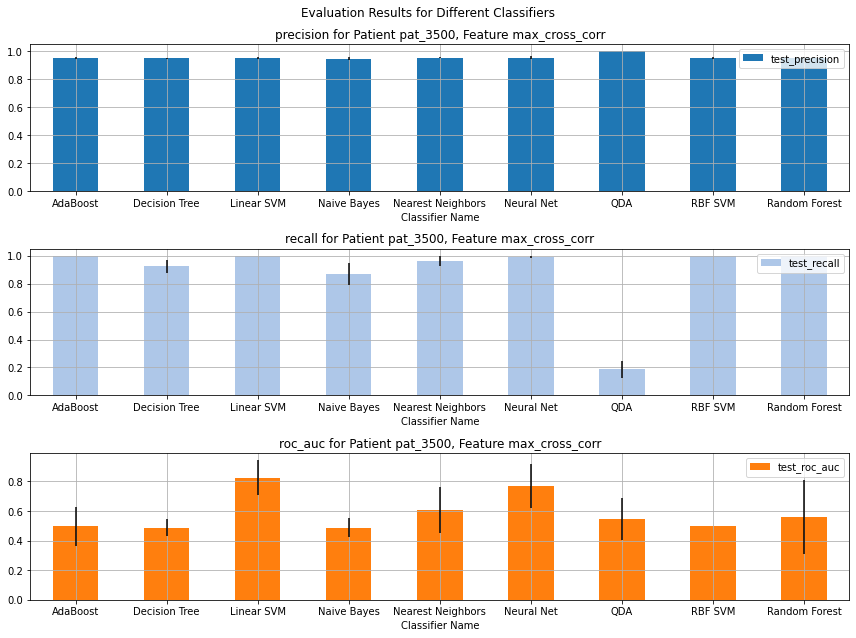

In [41]:
fig, axes = plt.subplots(3, figsize=(12, 9), sharex=False)
patient_results = results.loc[selected_patient, selected_feature, :].reset_index()

cs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']

colors = itertools.cycle(cs)
fig.suptitle('Evaluation Results for Different Classifiers')
for i, score in enumerate(('precision', 'recall', 'roc_auc')):
    plot_results_score(patient_results, patient_name=selected_patient, feature_name=selected_feature, score=score,
                       ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

## Evaluate single classifier
We saw that the Linear SVM gave the highest overall ROC AUC score. Let's go ahead and plot it's ROC curve.

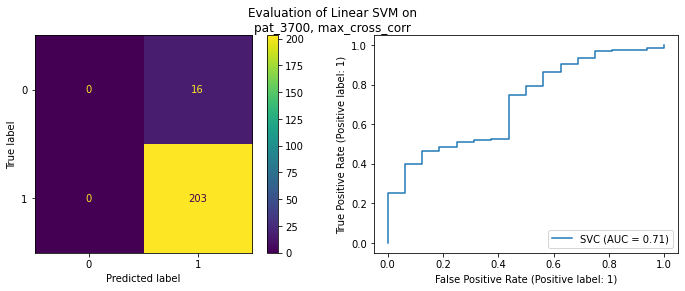

In [139]:
dataset = patients_datasets_df.query(f"feature_name == '{selected_feature}' and patient_name == '{selected_patient}'")
psp_dataset = PSPDataset(dataset.data_dir.item())

selected_classifier = 'Linear SVM'
selected_feature = 'max_cross_corr'
estimator = results.loc[selected_patient, selected_feature, selected_classifier, results['fold'] == 0].estimator.item()
X, labels = psp_dataset.get_X(), psp_dataset.get_labels()
le = LabelEncoder()
le.fit(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, le.transform(labels), test_size=0.4, random_state=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f'Evaluation of {selected_classifier} on\n{selected_patient}, {selected_feature}')
ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, ax=axes[0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=axes[1])

In [241]:
estimator = complete_results.loc['pat_3500', 'spect_corr', 'Linear SVM'].head(1).estimator.item()

C:\Users\noam\AppData\Local\Temp/ipykernel_5588/3976355709.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  estimator = complete_results.loc['pat_3500', 'spect_corr', 'Linear SVM'].head(1).estimator.item()


## Plot many AUC ROC Curves

In [292]:
best_index = complete_results.loc['pat_3700'].groupby(['feature_name', 'classifier_name']).mean().loc[:,'test_roc_auc'].nlargest(3)
print(f"{best_index=}")
estimators_df = complete_results.loc['pat_3700'].loc['spect_corr', 'Linear SVM']
# estimators_df = estimators_df.loc['Linear SVM']
estimators_df

best_index=feature_name    classifier_name
time_corr       Neural Net         0.743141
max_cross_corr  Neural Net         0.733045
spect_corr      Linear SVM         0.713878
Name: test_roc_auc, dtype: float64


C:\Users\noam\AppData\Local\Temp/ipykernel_5588/938651004.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  estimators_df = complete_results.loc['pat_3700'].loc['spect_corr', 'Linear SVM']


fold  fit_time  score_time  \
feature_name classifier_name                               
spect_corr   Linear SVM          0  3.140964    1.357000   
             Linear SVM          1  3.139001    1.354000   
             Linear SVM          2  3.028000    1.251000   
             Linear SVM          3  3.116001    1.312999   
             Linear SVM          4  3.147001    1.348000   

                                                  estimator  test_precision  \
feature_name classifier_name                                                  
spect_corr   Linear SVM       SVC(C=0.025, kernel='linear')        0.909091   
             Linear SVM       SVC(C=0.025, kernel='linear')        0.886364   
             Linear SVM       SVC(C=0.025, kernel='linear')        0.886364   
             Linear SVM       SVC(C=0.025, kernel='linear')        0.886364   
             Linear SVM       SVC(C=0.025, kernel='linear')        0.906977   

                              test_recall  test_roc_auc  \
feature_name classifier_name                              
spect_corr   Linear SVM               1.0      0.793750   
             Linear SVM               1.0      0.861538   
             Linear SVM               1.0      0.533333   
             Linear SVM               1.0      0.682051   
             Linear SVM               1.0      0.698718   

                                                                       data_dir  
feature_name classifier_name                                                     
spect_corr   Linear SVM       C:\Users\noam\Repositories\noamsgl\msc\results...  
             Linear SVM       C:\Users\noam\Repositories\noamsgl\msc\results...  
             Linear SVM       C:\Users\noam\Repositories\noamsgl\msc\results...  
             Linear SVM       C:\Users\noam\Repositories\noamsgl\msc\results...  
             Linear SVM       C:\Users\noam\Repositories\noamsgl\msc\results...

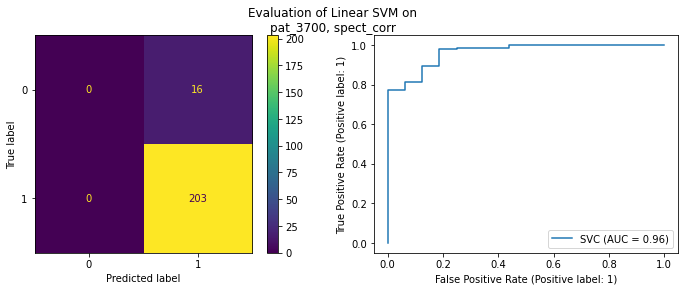

In [293]:
selected_patient = 'pat_3700'
selected_classifier = 'Linear SVM'
selected_feature = 'spect_corr'

estimator = estimators_df.iloc[1].loc['estimator']
dataset = datasets_df.query(f"feature_name == '{selected_feature}' and patient_name == '{selected_patient}'")

psp_dataset = PSPDataset(dataset.data_dir.item())

X, labels = psp_dataset.get_X(), psp_dataset.get_labels()
le = LabelEncoder()
le.fit(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, le.transform(labels), test_size=0.4, random_state=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f'Evaluation of {selected_classifier} on\n{selected_patient}, {selected_feature}')
ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, ax=axes[0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=axes[1])

## Running times for classifiers
Unsurprisingly, the neural network variations (MLPClassifier, SVMs) and the ensemble method, Adaboost took the most time to fit. Also somewhat surprising, is that the score times of the SVMs (on the test set) took even longer than the fit time (on the training set).

In [55]:
import pickle

results_fpath = r"C:\Users\noam\Repositories\noamsgl\msc\scripts\psp\training\complete_results.pkl"
results = pickle.load(open(results_fpath, 'rb'))

In [56]:
results

fold  fit_time  score_time  \
patient_name feature_name   classifier_name                                 
pat_3500     max_cross_corr Nearest Neighbors     0  0.009007    0.029949   
                            Nearest Neighbors     1  0.009052    0.024987   
                            Nearest Neighbors     2  0.008017    0.023984   
                            Nearest Neighbors     3  0.008016    0.023985   
                            Nearest Neighbors     4  0.008025    0.024949   
...                                             ...       ...         ...   
pat_7200     time_corr      QDA                   0  0.578084    0.033984   
                            QDA                   1  0.599321    0.035982   
                            QDA                   2  0.594086    0.037982   
                            QDA                   3  0.607116    0.037038   
                            QDA                   4  0.638007    0.034977   

                                                                         estimator  \
patient_name feature_name   classifier_name                                          
pat_3500     max_cross_corr Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
...                                                                            ...   
pat_7200     time_corr      QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   

                                               test_precision  test_recall  \
patient_name feature_name   classifier_name                                  
pat_3500     max_cross_corr Nearest Neighbors        0.951613     0.967213   
                            Nearest Neighbors        0.966102     0.934426   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.949153     0.918033   
...                                                       ...          ...   
pat_7200     time_corr      QDA                      0.916667     0.180328   
                            QDA                      0.937500     0.245902   
                            QDA                      1.000000     0.344262   
                            QDA                      0.866667     0.216667   
                            QDA                      1.000000     0.283333   

                                               test_roc_auc  \
patient_name feature_name   classifier_name                   
pat_3500     max_cross_corr Nearest Neighbors      0.577869   
                            Nearest Neighbors      0.568306   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.385246   
...                                                     ...   
pat_7200     time_corr      QDA                    0.300546   
                            QDA                    0.377049   
                            QDA                    0.770492   
                            QDA                    0.300000   
                            QDA                    0.838889   

                                                                                        dat

In [54]:
results = results.set_index(['patient_name', 'feature_name', 'classifier_name'])
results

KeyError: "None of ['patient_name', 'feature_name', 'classifier_name'] are in the columns"

In [48]:
selected_feature = "nonlin_interdep"
selected_patient = 'pat_3700'

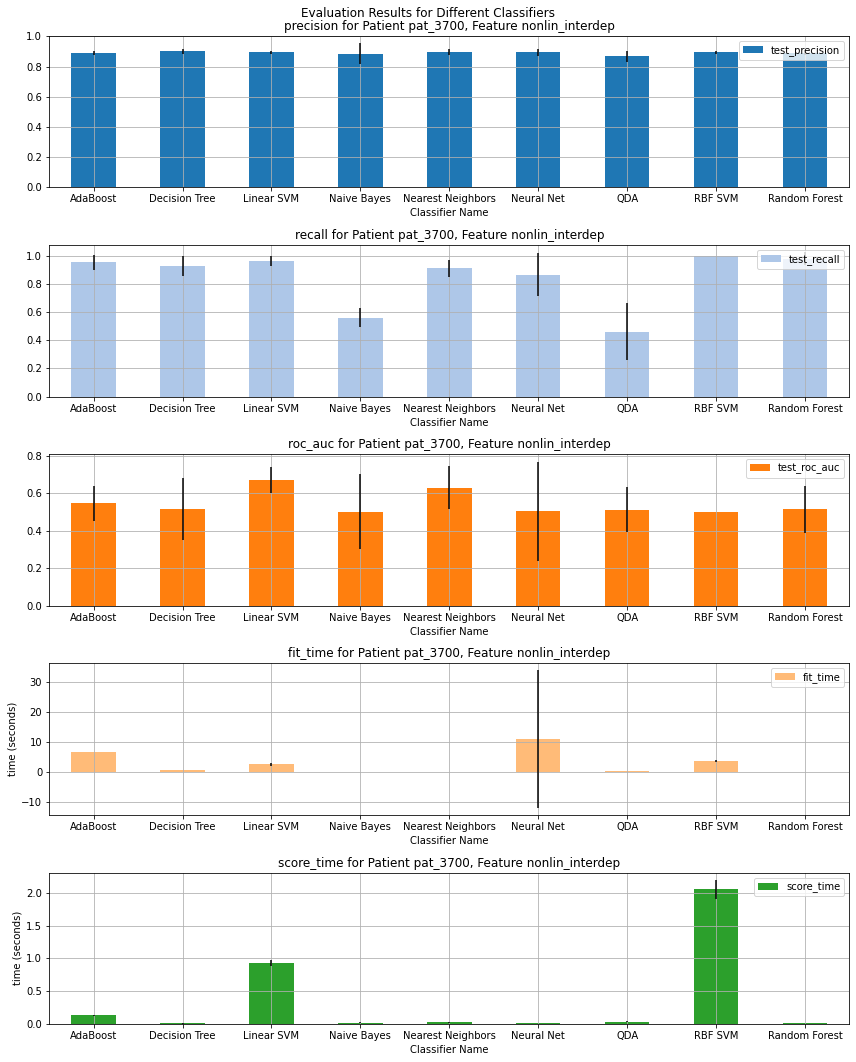

In [52]:
fig, axes = plt.subplots(5, figsize=(12, 3 * 5), sharex=False)
patient_results = results.loc[selected_patient, selected_feature, :].reset_index()

cs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']

colors = itertools.cycle(cs)
fig.suptitle('Evaluation Results for Different Classifiers')
for i, score in enumerate(('precision', 'recall', 'roc_auc')):
    plot_results_score(patient_results, patient_name=selected_patient, feature_name=selected_feature, score=score,
                       ax=axes[i], logy=False, color=next(colors))
for j, time_col in enumerate(('fit_time', 'score_time')):
    plot_results_time(patient_results, patient_name=selected_patient, feature_name=selected_feature, time_col=time_col,
                      ax=axes[j + i + 1], logy=False, color=next(colors))
plt.tight_layout()

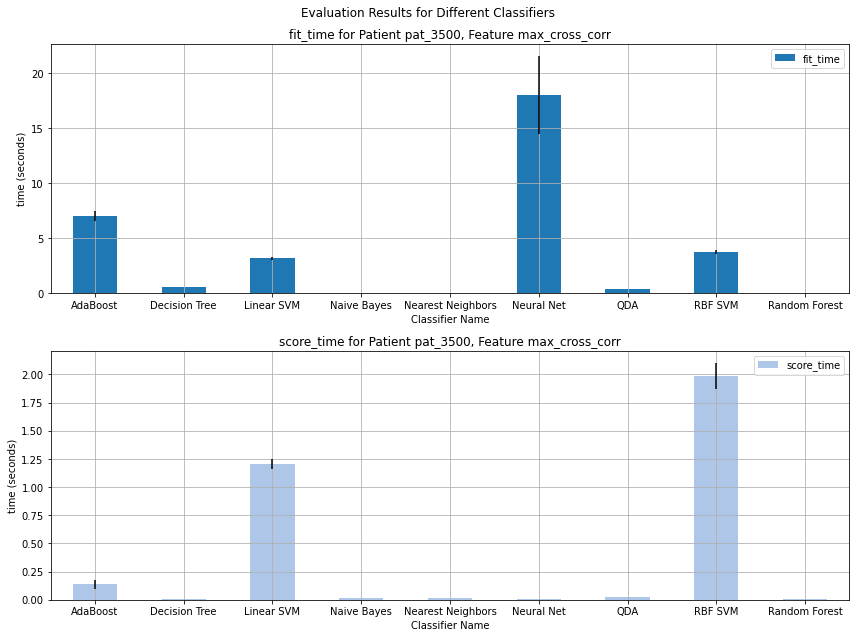

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 9), sharex=False)

colors = itertools.cycle(cs)

fig.suptitle('Evaluation Results for Different Classifiers')
for i, time_col in enumerate(('fit_time', 'score_time')):
    plot_results_time(patient_results, patient_name=selected_patient, feature_name=selected_feature, time_col=time_col,
                      ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

## Feature Selection
For feature selection, we will use the Recursive Feature Elimination algorithm to find a subset of features which balances optimally between minimal set size and maximal objective function.

In [51]:

estimator

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

In [114]:
estimator = results.loc['pat_3700', 'non', 'Random Forest', results['fold'] == 0].estimator.item()
selector = RFE(estimator, n_features_to_select=60 * 10)
selector = selector.fit(X, labels)

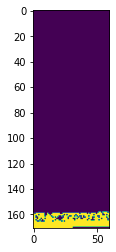

In [115]:
plt.imshow(selector.support_.reshape(-1, 60))

In [135]:
estimator = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].head(1).estimator.item()
selector = RFE(estimator, n_features_to_select=60 * 10)
selector = selector.fit(X, labels)

C:\Users\noam\AppData\Local\Temp/ipykernel_5588/303865837.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  estimator = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].head(1).estimator.item()


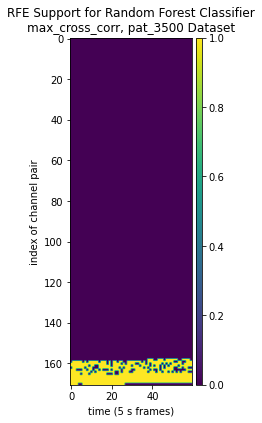

In [145]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(3,9))
plt.title(f"RFE Support for {'Random Forest Classifier'}\n{'max_cross_corr'}, {'pat_3500'} Dataset")
im = plt.imshow(selector.support_.reshape(-1, 60))
plt.xlabel('time (5 s frames)')
plt.ylabel('index of channel pair')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()

In [134]:
estimator = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].head(1).estimator.item()
estimator

C:\Users\noam\AppData\Local\Temp/ipykernel_5588/34559385.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  estimator = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].head(1).estimator.item()


RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

In [149]:
rfe_mask = selector.get_support().reshape(-1,60)

In [162]:
datasets_df.query("feature_name == 'max_cross_corr' and patient_name == 'pat_3500'").data_dir.item()

'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500\\20211213T182128'

In [165]:
from msc.dataset.dataset import MaskedDataset

masked_dataset = MaskedDataset(datasets_df.query("feature_name == 'max_cross_corr' and patient_name == 'pat_3500'").data_dir.item(), selector.get_support())

In [156]:
selector.get_support().shape

(10260,)

In [170]:
masked_X, labels = masked_dataset.get_masked_X(), masked_dataset.get_labels()

In [179]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

clf =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
num_folds = 5
scoring = ['precision', 'recall', 'roc_auc']

# X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    masked_X, labels, test_size=0.4, random_state=42
)
clf.fit(X_train, y_train)
cv_results = cross_validate(clf, X_test, y_test, cv=num_folds, scoring=scoring, return_estimator=True)
cv_results_df = pd.DataFrame(cv_results)

In [191]:
score_after = cv_results_df.mean().test_roc_auc

C:\Users\noam\AppData\Local\Temp/ipykernel_5588/322657411.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_after = cv_results_df.mean().test_roc_auc


In [189]:
score_before = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].mean().test_roc_auc

C:\Users\noam\AppData\Local\Temp/ipykernel_5588/157889836.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  score_before = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].mean().test_roc_auc
C:\Users\noam\AppData\Local\Temp/ipykernel_5588/157889836.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_before = complete_results.loc['pat_3500', 'max_cross_corr', 'Random Forest'].mean().test_roc_auc


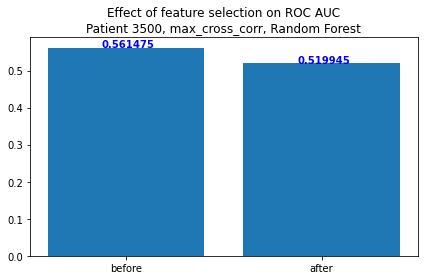

In [224]:
fig, ax = plt.subplots()
ax.set_title('Effect of feature selection on ROC AUC\nPatient 3500, max_cross_corr, Random Forest')
scores = [score_before, score_after]
ax.bar(["before", "after"], scores)
plt.text(-0.125, scores[0] + 0.00125, f'{scores[0]:2f}', color='blue', fontweight='bold')
plt.text(-0.125 + 1, scores[1] + 0.00125, f'{scores[1]:2f}', color='blue', fontweight='bold')
plt.tight_layout()